In [1]:
# === Cellule 1 : Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import joblib

# Chargement des données finales
df = pd.read_csv("nhanes_ready.csv")
print("Données chargées :", df.shape)


Données chargées : (6889, 38)


In [2]:
# Cellule 2 :

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SEQN                        6889 non-null   float64
 1   RIDAGEYR                    6889 non-null   float64
 2   RIAGENDR                    6889 non-null   int64  
 3   LBXTC                       6889 non-null   float64
 4   BMXHT                       6889 non-null   float64
 5   BMXBMI                      6889 non-null   float64
 6   BMXWT                       6889 non-null   float64
 7   BMXWAIST                    6889 non-null   float64
 8   BMXARMC                     6889 non-null   float64
 9   PAD680                      6889 non-null   float64
 10  SLD012                      6889 non-null   float64
 11  DRKCAL                      6889 non-null   float64
 12  DRPROT                      6889 non-null   float64
 13  DRSUGR                      6889 

In [3]:
# Cellule 3 : NaN

df.isna().sum().sum()


np.int64(0)

In [4]:
# Cellule 4 : doublons

df.duplicated().sum()


np.int64(0)

In [5]:
# Cellule 5 : Définition des features et de la cible ===

target = "chol_high"
features = ["RIDAGEYR", "RIAGENDR", "diabetes", "BMXBMI_log", "BMXHT", "BMXWT", "BMXWAIST", "BMXARMC",
            "PAD680_log", "SLD012", "DRKCAL_log", "DRPROT_log", "DRSUGR_log", "DRFIBE_log", "DRTFAT_log",
            "DRCARB_log", "DRWATER_log", "DRTALCO_log", "smoker", "ethnicity_MexicanAmerican",
            "ethnicity_NonHispanicAsian", "ethnicity_NonHispanicBlack", "ethnicity_NonHispanicWhite",
            "ethnicity_OtherHispanic", "ethnicity_OtherRace"
           ] 


X = df[features]
y = df[target]

print(" Variables prêtes pour la modélisation")
print(f"Nombre de features : {X.shape[1]}")
print(f"Nombre d'observations : {X.shape[0]}")
print(f"Variable cible : {target}")

# Vérification de la répartition de la cible
print("Répartition de la variable cible :")
print(y.value_counts())
print("Pourcentages :")
print((y.value_counts(normalize=True) * 100).round(2))


 Variables prêtes pour la modélisation
Nombre de features : 25
Nombre d'observations : 6889
Variable cible : chol_high
Répartition de la variable cible :
chol_high
0    6272
1     617
Name: count, dtype: int64
Pourcentages :
chol_high
0    91.04
1     8.96
Name: proportion, dtype: float64


In [6]:
# Cellule 6 : Split stratifié train/val/test 

# Étape 1 : découpage train + test (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Étape 2 : découpage train + val (sur les 80 % restants)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,   # 25 % de 80 % = 20 % du total
    stratify=y_train_full,
    random_state=42
)

print(" Split effectué :")
print(f"Train : {X_train.shape[0]} individus ({(X_train.shape[0]/len(X))*100:.1f} %)")
print(f"Validation : {X_val.shape[0]} individus ({(X_val.shape[0]/len(X))*100:.1f} %)")
print(f"Test : {X_test.shape[0]} individus ({(X_test.shape[0]/len(X))*100:.1f} %)")

print("Répartition des classes :")
print("Train :", y_train.value_counts(normalize=True).round(3).to_dict())
print("Val   :", y_val.value_counts(normalize=True).round(3).to_dict())
print("Test  :", y_test.value_counts(normalize=True).round(3).to_dict())


 Split effectué :
Train : 4133 individus (60.0 %)
Validation : 1378 individus (20.0 %)
Test : 1378 individus (20.0 %)
Répartition des classes :
Train : {0: 0.91, 1: 0.09}
Val   : {0: 0.91, 1: 0.09}
Test  : {0: 0.911, 1: 0.089}


In [7]:
# Cellule 7 : Standardisation des variables numériques
from sklearn.preprocessing import StandardScaler

# Colonnes binaires à NE PAS standardiser
binary_cols = [
    "RIAGENDR", "diabetes", "smoker",
    "ethnicity_MexicanAmerican", "ethnicity_NonHispanicAsian",
    "ethnicity_NonHispanicBlack", "ethnicity_NonHispanicWhite",
    "ethnicity_OtherHispanic", "ethnicity_OtherRace"
]

# Colonnes numériques à standardiser (toutes les autres)
num_cols = [col for col in X_train.columns if col not in binary_cols]

print(f"Nombre de colonnes à standardiser : {len(num_cols)}")
print(num_cols)

# Initialisation du scaler
scaler = StandardScaler()

# Fit sur le train uniquement
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Application sur val et test avec les mêmes paramètres
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Sauvegarde du scaler pour réutilisation (API, etc.)
joblib.dump(scaler, "scaler_chol.pkl")

print("Standardisation effectuée uniquement sur le train")
print("Scaler sauvegardé : scaler_chol.pkl")
print(f"Dimensions finales — X_train : {X_train.shape}, X_val : {X_val.shape}, X_test : {X_test.shape}")


Nombre de colonnes à standardiser : 16
['RIDAGEYR', 'BMXBMI_log', 'BMXHT', 'BMXWT', 'BMXWAIST', 'BMXARMC', 'PAD680_log', 'SLD012', 'DRKCAL_log', 'DRPROT_log', 'DRSUGR_log', 'DRFIBE_log', 'DRTFAT_log', 'DRCARB_log', 'DRWATER_log', 'DRTALCO_log']
Standardisation effectuée uniquement sur le train
Scaler sauvegardé : scaler_chol.pkl
Dimensions finales — X_train : (4133, 25), X_val : (1378, 25), X_test : (1378, 25)


In [8]:
# Cellule 8 : Vérification de la standardisation 

# On vérifie la moyenne et l'écart-type dans le jeu d'entraînement
stats = pd.DataFrame({
    "mean": X_train[num_cols].mean().round(2),
    "std": X_train[num_cols].std().round(2)
})

print("=== Vérification standardisation (train uniquement) ===")
display(stats)

# Vérification rapide sur val/test
mean_val = np.abs(X_val[num_cols].mean()).mean().round(2)
std_val = X_val[num_cols].std().mean().round(2)

mean_test = np.abs(X_test[num_cols].mean()).mean().round(2)
std_test = X_test[num_cols].std().mean().round(2)

print(f"\nValidation : moyenne abs = {mean_val}, écart-type moyen = {std_val}")
print(f"Test : moyenne abs = {mean_test}, écart-type moyen = {std_test}")


=== Vérification standardisation (train uniquement) ===


,mean,std
RIDAGEYR,0.0,1.0
BMXBMI_log,-0.0,1.0
BMXHT,-0.0,1.0
BMXWT,-0.0,1.0
BMXWAIST,0.0,1.0
BMXARMC,-0.0,1.0
PAD680_log,-0.0,1.0
SLD012,-0.0,1.0
DRKCAL_log,0.0,1.0
DRPROT_log,0.0,1.0



Validation : moyenne abs = 0.03, écart-type moyen = 1.0
Test : moyenne abs = 0.02, écart-type moyen = 0.97


In [9]:
#  Cellule 9 : Entraînement du modèle LightGBM
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Création du modèle avec paramètres de base
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'  # utile si classes déséquilibrées
)

# Entraînement avec early stopping
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Sauvegarde du modèle
joblib.dump(lgb_model, "model_lightgbm_chol.pkl")
print("Modèle LightGBM entraîné et sauvegardé : model_lightgbm_chol.pkl")


[LightGBM] [Info] Number of positive: 370, number of negative: 3763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 4133, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.727697	valid_0's binary_logloss: 0.499621
Modèle LightGBM entraîné et sauvegardé : model_lightgbm_chol.pkl


=== RAPPORT DE CLASSIFICATION (TEST) ===
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1255
           1       0.17      0.59      0.27       123

    accuracy                           0.71      1378
   macro avg       0.56      0.66      0.54      1378
weighted avg       0.88      0.71      0.77      1378

ROC AUC (test) : 0.7170


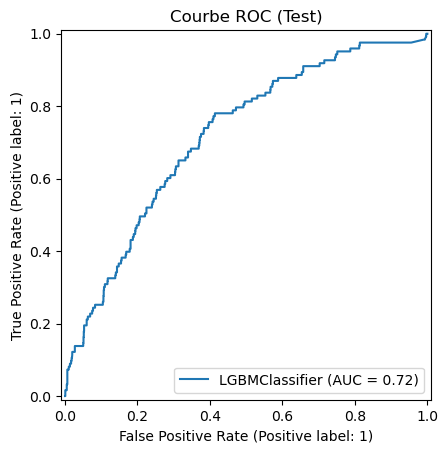

In [10]:
# === Cellule 10 : Évaluation finale sur le jeu de test ===
y_test_pred = lgb_model.predict(X_test)
y_test_proba = lgb_model.predict_proba(X_test)[:, 1]

print("=== RAPPORT DE CLASSIFICATION (TEST) ===")
print(classification_report(y_test, y_test_pred))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC (test) : {roc_auc_test:.4f}")

# Courbe ROC
RocCurveDisplay.from_estimator(lgb_model, X_test, y_test)
plt.title("Courbe ROC (Test)")
plt.show()


In [11]:
# Cellule 11:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from scipy.stats import randint, uniform

param_dist = {
    "num_leaves": randint(15, 60),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.09),
    "n_estimators": randint(200, 1000),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "scale_pos_weight": uniform(1, 5)  # pondération des positifs
}

lgb_clf = lgb.LGBMClassifier(random_state=42)

rs = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

rs.fit(X_train, y_train)
print("Meilleurs hyperparamètres :", rs.best_params_)
best_lgb = rs.best_estimator_


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 370, number of negative: 3763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 4133, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.089523 -> initscore=-2.319469
[LightGBM] [Info] Start training from score -2.319469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [12]:
# Cellule 12

y_pred_test = best_lgb.predict(X_test)
y_proba_test = best_lgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_test))
print("ROC AUC (test) :", roc_auc_score(y_test, y_proba_test))


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1255
           1       0.20      0.24      0.22       123

    accuracy                           0.84      1378
   macro avg       0.56      0.57      0.57      1378
weighted avg       0.86      0.84      0.85      1378

ROC AUC (test) : 0.7031062740906292


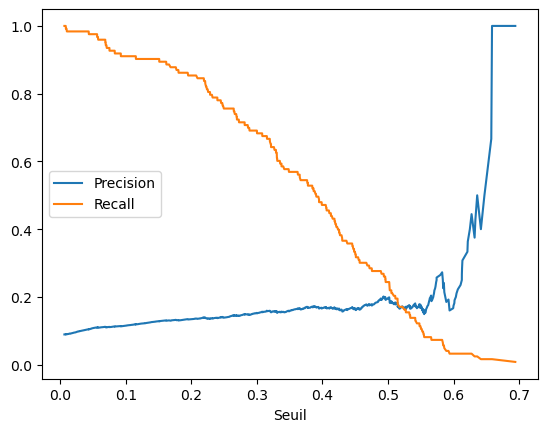

              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1255
           1       0.15      0.69      0.25       123

    accuracy                           0.63      1378
   macro avg       0.55      0.66      0.50      1378
weighted avg       0.88      0.63      0.71      1378



In [21]:
# Cellule 13

from sklearn.metrics import precision_recall_curve

y_scores = best_lgb.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_scores)

plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Seuil")
plt.legend()
plt.show()

# Exemple : choisir seuil = 0.3
y_pred_custom = (y_scores >= 0.3).astype(int)
print(classification_report(y_test, y_pred_custom))
